In [17]:
# =============================================================================
# Example Iris Segmentation code using DINOv3
# Rasel Ahmed Bhuiyan, Adam Czajka | {rbhuiyan,aczajka}@nd.edu
# University of Notre Dame | AITAR Lab https://lucyinstitute.nd.edu/aitar
# =============================================================================

In [2]:
import os
import requests
import subprocess
import pickle
import matplotlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.transforms.functional as TF
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set device

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# Set directory paths

In [4]:
# Root directory
ROOT_DIR = "/content/drive/MyDrive/Iris-Segmentation-DINOv3"

# Dataset directories
DATASET_DIR = os.path.join(ROOT_DIR, "trainset")
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
MASKS_DIR = os.path.join(DATASET_DIR, "masks")

# Repository directory
REPO_DIR = os.path.join(ROOT_DIR, "dinov3-main")

# DINOv3 weights directory
WEIGHTS_DIR = f"{ROOT_DIR}/dinov3-main/weights"

# Output directories
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Create custom iris dataset loader

In [5]:
def load_iris_dataset(image_dir: str, mask_dir: str):
    """
    Load images and corresponding masks (expects same filenames in both directories).

    Returns:
        images: list of PIL.Image RGB images
        masks: list of PIL.Image grayscale images ('L')
    """
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith('.bmp')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith('.bmp')])

    if len(image_files) != len(mask_files):
        raise AssertionError(f"Number of images ({len(image_files)}) and masks ({len(mask_files)}) don't match")

    images: List[Image.Image] = []
    masks: List[Image.Image] = []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)

        img = Image.open(img_path).convert('RGB')
        m = Image.open(mask_path)
        if m.mode != 'L':
            m = m.convert('L')

        images.append(img)
        masks.append(m)

    return images, masks


def resize_transform(mask_image: Image.Image, image_size: int, patch_size: int) -> torch.Tensor:
    """
    Resize an image so that both height and width are divisible by patch_size.

    Args:
        mask_image (Image.Image): Input PIL image (mask).
        image_size (int): Target height for resizing.
        patch_size (int): Patch size to align dimensions.

    Returns:
        torch.Tensor: Resized image as a tensor.
    """
    w, h = mask_image.size

    # Calculate number of patches along height and width
    h_patches = image_size // patch_size
    w_patches = (w * image_size) // (h * patch_size)

    # Resize image to make dimensions divisible by patch_size
    resized = TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size))
    return TF.to_tensor(resized)

# Load data

In [6]:
# Set how many images you want to take for training
N = 10
images, labels = load_iris_dataset(IMAGES_DIR, MASKS_DIR)
images, labels = images[0:N], labels[0:N]
n_images = len(images)
print(f"Loaded {n_images} iris images and masks")

Loaded 10 iris images and masks


# Loaded data visualization (image, mask, foreground, background)

In [7]:
def visualize_image_mask(image, mask, figsize=(4, 2), title_fontsize=8):
    # Ensure mask is in 'L' mode (grayscale)
    if mask.mode != 'L':
        mask = mask.convert('L')

    # Foreground: iris visible, rest white
    foreground = Image.composite(image, Image.new('RGB', image.size, (255, 255, 255)), mask)

    # Background: iris white, rest visible
    background = Image.composite(Image.new('RGB', image.size, (255, 255, 255)), image, mask)

    # Prepare data for plotting
    data_to_show = [image, mask, foreground, background]
    data_labels = ["Image", "Mask", "Foreground", "Background"]

    # Plot
    plt.figure(figsize=figsize, dpi=300)
    for i, item in enumerate(data_to_show):
        plt.subplot(1, len(data_to_show), i + 1)
        plt.imshow(item)
        plt.axis('off')
        plt.title(data_labels[i], fontsize=title_fontsize)
    plt.tight_layout()
    plt.show()

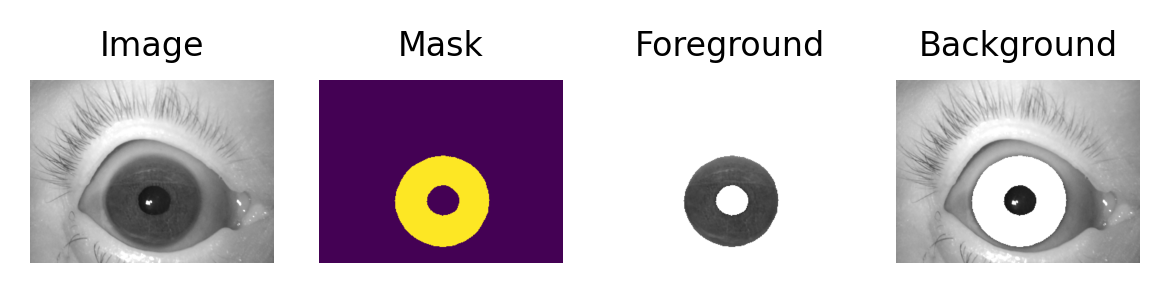

In [8]:
# Visualize the first image/mask pair
data_index = 0
visualize_image_mask(images[data_index], labels[data_index])

# Load Pre-trained DINOv3 Model

In [9]:

# --- Model Definitions -------------------------------------------------------

MODEL_DINOV3_VITS   = "dinov3_vits16"
MODEL_DINOV3_VITSP  = "dinov3_vits16plus"
MODEL_DINOV3_VITB   = "dinov3_vitb16"
MODEL_DINOV3_VITL   = "dinov3_vitl16"
MODEL_DINOV3_VITHP  = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B  = "dinov3_vit7b16"

MODEL_DINOV3_CONVNEXT_T   = "dinov3_convnext_tiny"
MODEL_DINOV3_CONVNEXT_S   = "dinov3_convnext_small"
MODEL_DINOV3_CONVNEXT_B   = "dinov3_convnext_base"
MODEL_DINOV3_CONVNEXT_L   = "dinov3_convnext_large"


# --- Weights Mapping ---------------------------------------------------------

WEIGHTS_MAP = {
    MODEL_DINOV3_VITS: {
        "filename": "dinov3_vits16_pretrain_lvd1689m-08c60483.pth",
        "url": "https://notredame.box.com/s/ckjlj4jlkct9jznydh4p5blkd2oimn2u"
    },
    MODEL_DINOV3_VITSP: {
        "filename": "dinov3_vits16plus_pretrain_lvd1689m-4057cbaa.pth",
        "url": "https://notredame.box.com/s/ul6rjwygma7kdjhzhs0d4amvmr6wszkl"
    },
    MODEL_DINOV3_VITB: {
        "filename": "dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth",
        "url": "https://notredame.box.com/s/o3uqvgi5bia61gtcxqn43cdn32bh81mi"
    },
    MODEL_DINOV3_VITL: {
        "filename": "dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth",
        "url": "https://notredame.box.com/s/pxcs4yobuh3ov38oue3p22imvpaqvfn7"
    },
    MODEL_DINOV3_VITHP: {
        "filename": "dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth",
        "url": "https://notredame.box.com/s/cy6jiqwqkdhk8mc3532kyvuy8yvvk0wz"
    },
    MODEL_DINOV3_VIT7B: {
        "filename": "dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth",
        "url": "https://notredame.box.com/s/ytj4vvei648hog0wnet8m60pmqxqiouo"
    },
    MODEL_DINOV3_CONVNEXT_T: {
        "filename": "dinov3_convnext_tiny_pretrain_lvd1689m-21b726bb.pth",
        "url": "https://notredame.box.com/s/jt4wtzi23l7x5l8tgiqwvo10iecm62y2"
    },
    MODEL_DINOV3_CONVNEXT_S: {
        "filename": "dinov3_convnext_small_pretrain_lvd1689m-296db49d.pth",
        "url": "https://notredame.box.com/s/95r8w1fko1lh3gwwok9x4pspbi530ta5"
    },
    MODEL_DINOV3_CONVNEXT_B: {
        "filename": "dinov3_convnext_base_pretrain_lvd1689m-801f2ba9.pth",
        "url": "https://notredame.box.com/s/eti462dwvto28wy4u0l4ghukgrmu8exv"
    },
    MODEL_DINOV3_CONVNEXT_L: {
        "filename": "dinov3_convnext_large_pretrain_lvd1689m-61fa432d.pth",
        "url": "https://notredame.box.com/s/8fbhhy47xoj7839hl52ijpiqrlxioyol"
    },
}



def convert_box_to_direct(shared_url):
    """Attempt to convert Box shared link to direct download"""
    # Extract the file ID
    if '/s/' in shared_url:
        file_id = shared_url.split('/s/')[1].split('/')[0]
        return f"https://app.box.com/shared/static/{file_id}"
    return shared_url


# --- Select Model ------------------------------------------------------------

MODEL_NAME = MODEL_DINOV3_VITL  # <--- change here


# Path for the chosen weights
WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, WEIGHTS_MAP[MODEL_NAME]["filename"])
BOX_WEIGHTS_URL = convert_box_to_direct(WEIGHTS_MAP[MODEL_NAME]["url"])

# --- Ensure Weights Exist ----------------------------------------------------

if not os.path.exists(WEIGHTS_PATH):
    print(f"Weights not found locally: {WEIGHTS_PATH}")
    print("Downloading from Box folder...")

    os.makedirs(WEIGHTS_DIR, exist_ok=True)
    !wget -q -L -O "{WEIGHTS_PATH}" --show-progress --progress=bar:force "{BOX_WEIGHTS_URL}"
    print("\nWeights downloaded successfully")

else:
    print(f"Found weights locally at {WEIGHTS_PATH}")


Weights not found locally: /content/drive/MyDrive/Iris-Segmentation-DINOv3/dinov3-main/weights/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth
/content/drive/MyDr 100%[===================>]   1.13G  67.6MB/s    in 20s     

Weights downloaded successfully


In [10]:
# --- Load Model --------------------------------------------------------------

print(f"Loading {MODEL_NAME} from {WEIGHTS_PATH}")
model = torch.hub.load(
    repo_or_dir=REPO_DIR,
    model=MODEL_NAME,
    source="local",
    weights=WEIGHTS_PATH
)

model.eval().to(device)

print("\nWeights loaded successfully")
print(f"\n\nModel architecture:\n{model}")

Loading dinov3_vitl16 from /content/drive/MyDrive/Iris-Segmentation-DINOv3/dinov3-main/weights/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth
Downloading: "file:///content/drive/MyDrive/Iris-Segmentation-DINOv3/dinov3-main/weights/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth


100%|██████████| 1.13G/1.13G [00:05<00:00, 221MB/s]



Weights loaded successfully


Model architecture:
DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-23): 24 x SelfAttentionBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
 

## Building Per-Patch Label Map

In [11]:
def plot_mask_quantization(masks, patch_quant_filter, resize_transform, image_height, patch_size):
    """
    Visualize how a mask is transformed from pixel-level labels into
    patch-level labels using quantization.
    """
    # Extract the mask from the first sample (take the last channel if multi-channel)
    mask_0 = masks[0].split()[-1]

    # Resize mask so its dimensions are divisible by patch_size
    mask_0_resized = resize_transform(mask_0, image_height, patch_size)

    # Apply quantization filter (average pooling over non-overlapping patches)
    with torch.no_grad():
        mask_0_quantized = patch_quant_filter(mask_0_resized).squeeze().detach().cpu()

    # Plot side-by-side: original vs. quantized
    plt.figure(figsize=(3, 2), dpi=300)

    plt.subplot(1, 2, 1)
    plt.imshow(mask_0)
    plt.axis('off')
    plt.title(f"Original Mask, Size {mask_0.size}", fontsize=5)

    plt.subplot(1, 2, 2)
    plt.imshow(mask_0_quantized)
    plt.axis('off')
    plt.title(f"Quantized Mask, Size {tuple(mask_0_quantized.shape)}", fontsize=5)

    plt.tight_layout()
    plt.show()

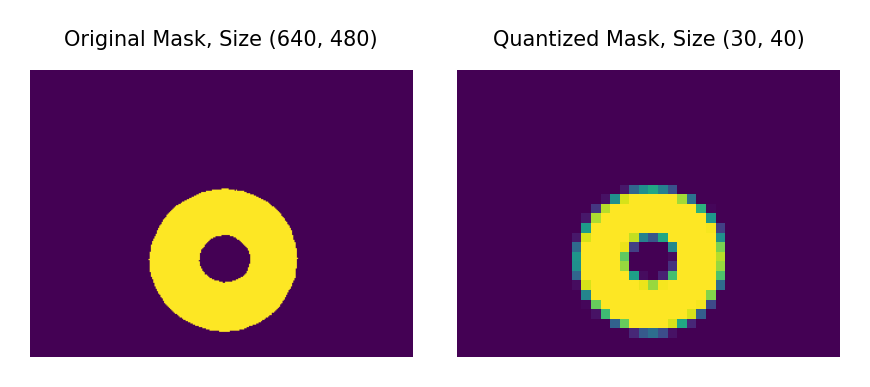

In [12]:
# Since the DINOv3 model operates on non-overlapping 16x16 patches.
# To align labels with model inputs, we have to quantize ground truth masks to a 16x16 pixel grid.
IMAGE_SIZE = 480
PATCH_SIZE = 16

# --- Quantization Filter ------------------------------------------------------

# Fixed convolution that averages over each PATCH_SIZE x PATCH_SIZE region
# Equivalent to non-learnable average pooling
patch_quant_filter = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=PATCH_SIZE,
    stride=PATCH_SIZE,
    bias=False
)
# Fill kernel with uniform weights so each pixel contributes equally
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))


# Visualize the first mask before and after quantization
plot_mask_quantization(labels, patch_quant_filter, resize_transform, IMAGE_SIZE, PATCH_SIZE)

# Extracting Features and Labels for all the images using DINOv3

In [13]:
# Standard ImageNet normalization stats
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# Model layers mapping
MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
    MODEL_DINOV3_CONVNEXT_T: 3,
    MODEL_DINOV3_CONVNEXT_S: 3,
    MODEL_DINOV3_CONVNEXT_B: 3,
    MODEL_DINOV3_CONVNEXT_L: 3,
}


# Features and labels list
xs_list = []
ys_list = []
image_idx_list = []

n_images = len(images)
n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]


# --- Feature extraction ----------------------------------
# Use inference_mode + autocast for faster, memory-efficient inference.
with torch.inference_mode():
    with torch.autocast(device_type=device, dtype=torch.float32):
        for i in tqdm(range(n_images), desc="Extracting DINOv3 features"):

            # -------------------- Mask processing --------------------
            # Get corresponding mask and resize to be divisible by PATCH_SIZE
            mask = labels[i]
            mask_resized = resize_transform(mask, IMAGE_SIZE, PATCH_SIZE)

            # If mask has multiple channels, collapse to a single channel by averaging.
            if mask_resized.shape[0] != 1:
                mask_resized = mask_resized.mean(dim=0, keepdim=True)

            # Quantize by averaging each non-overlapping patch.
            mask_quant = patch_quant_filter(mask_resized.unsqueeze(0)).squeeze(0).squeeze(0).view(-1).detach().cpu()
            ys_list.append(mask_quant)


            # -------------------- Image processing --------------------
            # Ensure image is RGB (3 channels) and resized to patch grid.
            image = images[i].convert('RGB')
            image_resized = resize_transform(image, IMAGE_SIZE, PATCH_SIZE)

            # Normalize data
            image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_batch = image_resized.unsqueeze(0).to(device)

            # Extract intermediate representations from the DINOv3 model
            feats = model.get_intermediate_layers(image_batch, n=range(n_layers), reshape=True, norm=True)

            # Use the last feature map (highest-level features)
            last_feat = feats[-1]  # shape: (B, C, H_patch, W_patch)

            # Convert to (num_patches, dim)
            dim = last_feat.shape[1]
            patch_feats = last_feat.squeeze(0).view(dim, -1).permute(1, 0).detach().cpu()  # (num_patches, dim)
            xs_list.append(patch_feats)

            # Record image index for each patch
            image_idx_list.append(i * torch.ones(ys_list[-1].shape))


# --- Concatenate per-image lists into torch tensors ------------------
xs = torch.cat(xs_list, dim=0)
ys = torch.cat(ys_list, dim=0)
image_index = torch.cat(image_idx_list, dim=0)


# --- Filter ambiguous patch labels ------------------------------------------
# Keep only patches that are clearly background (near 0) or foreground (near 1).
idx = (ys < 0.01) | (ys > 0.99)
xs = xs[idx]
ys = ys[idx]
image_index = image_index[idx]

print("\nFeature matrix size :", xs.shape)
print("Label matrix size  :", ys.shape)

Extracting DINOv3 features: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Feature matrix size : torch.Size([11338, 1024])
Label matrix size  : torch.Size([11338])


# Train segmentation model utilizing DINOv3 features

In [14]:
# In this stage, we train a simple linear classifier (logistic regression) on the
# patch-level features extracted from DINOv3. To choose the best regularization
# strength (C), we perform a hyperparameter search with leave-one-image-out
# cross-validation and evaluate using Average Precision (AP).

cs = np.logspace(-7, 0, 8)
scores = np.zeros((n_images, len(cs)))

for i in range(n_images):
    print('validation using image_{:02d}.jpg'.format(i + 1))
    train_mask = image_index != float(i)
    val_mask = ~train_mask

    fold_x = xs[train_mask].numpy()
    fold_y = (ys[train_mask] > 0).long().numpy()
    val_x = xs[val_mask].numpy()
    val_y = (ys[val_mask] > 0).long().numpy()

    for j, c in enumerate(cs):
        print("training logisitic regression with C={:.2e}".format(c))
        clf = LogisticRegression(random_state=0, C=c, max_iter=10000).fit(fold_x, fold_y)
        output = clf.predict_proba(val_x)[:, 1]
        scores[i, j] = average_precision_score(val_y, output)

# Compute mean AP for each C across all folds
mean_scores = scores.mean(axis=0)

# Select the best C
best_c_index = np.argmax(mean_scores)
best_c = cs[best_c_index]

print(f"Best C automatically selected: {best_c:.2e} with mean AP = {mean_scores[best_c_index]:.4f}")

validation using image_01.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00
validation using image_02.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00
validation using image_03.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C

In [15]:
# Retrain the logistic regression classifier with the best C and save it
clf = LogisticRegression(random_state=0, C=best_c, max_iter=100000, verbose=2).fit(xs.numpy(), (ys > 0).long().numpy())

# Save the trained segmentor for later inference
model_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_iris_segmentor.pkl")
with open(model_path, "wb") as f:
    pickle.dump(clf, f)

print(f"Saved segmentor to {model_path}")

Saved segmentor to /content/drive/MyDrive/Iris-Segmentation-DINOv3/checkpoints/dinov3_vitl16_iris_segmentor.pkl


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


# Test save model

Loaded trained segmentor from /content/drive/MyDrive/Iris-Segmentation-DINOv3/checkpoints/dinov3_vitl16_iris_segmentor.pkl


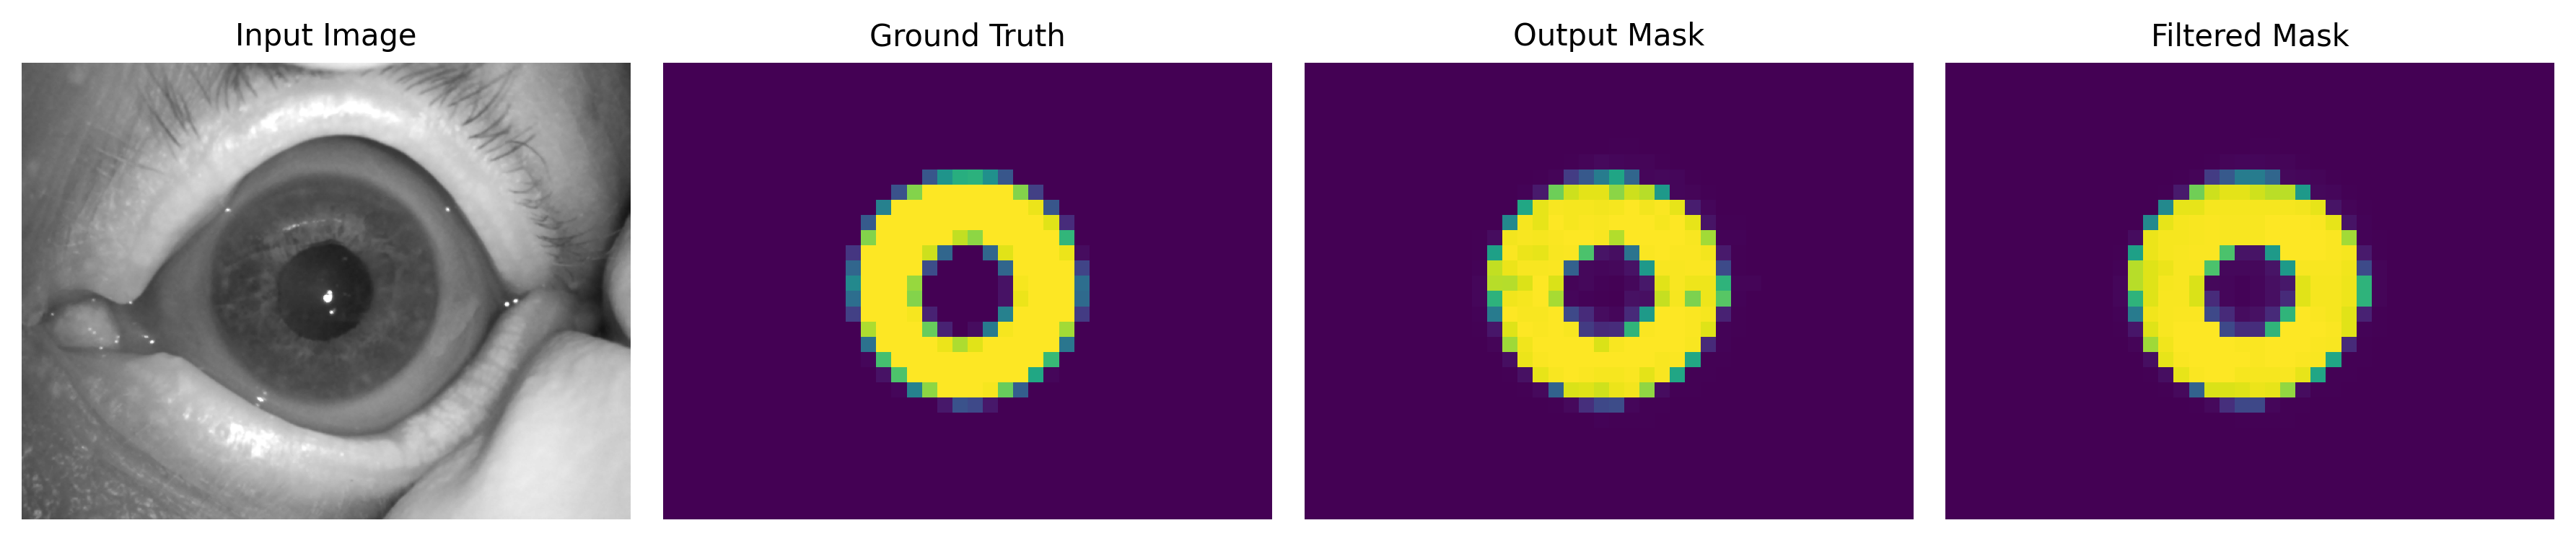

In [16]:
# Load the Trained Segmentor
model_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_iris_segmentor.pkl")

if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        clf = pickle.load(f)
    print(f"Loaded trained segmentor from {model_path}")
else:
    raise FileNotFoundError(f"Trained segmentor not found at {model_path}")


# Define test image and mask paths
test_image_fpath = f"{ROOT_DIR}/testset/images/9081L_1_1.bmp"
test_mask_fpath = f"{ROOT_DIR}/testset/masks/9081L_1_1.bmp"

# Load and preprocess test image
test_image = Image.open(test_image_fpath).convert("RGB")
test_image_resized = resize_transform(test_image, IMAGE_SIZE, PATCH_SIZE)
test_image_normalized = TF.normalize(test_image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

# Load and preprocess test mask
test_mask = Image.open(test_mask_fpath).convert("L")
test_mask_resized = resize_transform(test_mask, IMAGE_SIZE, PATCH_SIZE)
with torch.no_grad():
    test_mask_quantized = patch_quant_filter(test_mask_resized).squeeze().detach().cpu()


# Feature Extraction from DINOv3
with torch.inference_mode():
    feats = model.get_intermediate_layers(
        test_image_normalized.unsqueeze(0).to(device),
        n=range(n_layers),
        reshape=True,
        norm=True
    )
    last_feat = feats[-1].squeeze().detach().cpu()  # (C, H_patch, W_patch)

    dim = last_feat.shape[0]
    x = last_feat.view(dim, -1).permute(1, 0)  # (num_patches, dim)


# Prediction with Trained Classifier
# Reshape classifier outputs back into patch grid
h_patches, w_patches = [int(d / PATCH_SIZE) for d in test_image_resized.shape[1:]]
fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)

# Apply median filtering to smooth predictions
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))


# Segmentation visualization
plt.figure(figsize=(12, 3), dpi=300)

plt.subplot(1, 4, 1)
plt.imshow(test_image_resized.permute(1, 2, 0))
plt.axis("off")
plt.title("Input Image", fontsize=10)

plt.subplot(1, 4, 2)
plt.imshow(test_mask_quantized)
plt.axis("off")
plt.title("Ground Truth", fontsize=10)

plt.subplot(1, 4, 3)
plt.imshow(fg_score)
plt.axis("off")
plt.title("Output Mask", fontsize=10)

plt.subplot(1, 4, 4)
plt.imshow(fg_score_mf)
plt.axis("off")
plt.title("Filtered Mask", fontsize=10)

plt.tight_layout()
plt.show()